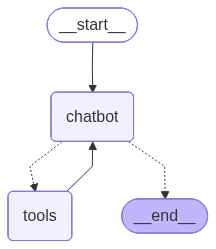

In [ ]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

tool = TavilySearchResults(max_results=2)
tools = [tool]

# tool.invoke("Langgraphのノードとは？")

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# ステートグラフの可視化
# from IPython.display import Image, display
# display(Image(graph.get_graph().draw_mermaid_png()))


In [9]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどんなことをお手伝いできますか？
1+2は？
1 + 2 は 3 です。何か他に聞きたいことがありますか？
1メートル以上の魚は？

[{"url": "https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q13314731133", "content": "JavaScriptが無効です。ブラウザの設定でJavaScriptを有効にしてください。  \nJavaScriptを有効にするには\n\n回答受付が終了しました\n\nID非表示さん\n\n2025/5/8 14:21\n\n8回答\n\n# 海釣りの魚釣りで、全長１mを超える魚を釣り上げたら、どうやってコンパクトカーな車に乗せる。 魚を家に持って帰るの大変ですか？ 食べきれないから冷凍して小分けにするしかないですか？\n\n釣り | シニアライフ、シルバーライフ・140閲覧\n\n## 回答（8件）\n\n春夏秋冬さん\n\n2025/5/9 17:45\n\n問題は、想定している魚種と、保冷状態で持ち帰れる術があるかですね。\n私の場合、ミニバンなんでコンパクトカーのケースではないけど、7-8年前、フィクセル３０００（内寸幅44cm程度）での夏のＳＬＪ釣行時に８０ｃｍ超えのサワラが釣れた時は、頭を落として、胴体は肛門部分から真っ二つに分断してクーラーへ納めて持ち帰りましたよ。\nちなみに、勿体ないので冷凍せずに、処理と保冷保管で約5日間程度で家族3人で食べ尽くしました。\nもし、食べきれないと最初から判断しているなら冷凍もありだと思うけど。\n取りあえず、頭が落とせる装備があれば、胴体も分断できるので、やっぱり問題は車載可能なサイズのクーラー等の有無だと思うよ。\nちなみに、太刀魚なら問答無用で頭落として、「流石にここから先（尻尾側）は食わん」という位置でカットしてクーラー行きです。\n\nこの回答はいかがでしたか？ リアクションしてみよう\n\nなるほど\n\n0\n\nそうだね\n\n0\n\nありがとう\n\n0\n\n新・KWMTさん\n\n2025/5/9 15:40\n\n1m程度なら、曲げて袋に入れれば車に入りますよ。\n\nなるほど\n\n0\n\nそうだね\n\n0\n\nありがとう\n\n0